In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import numpy as np
import pandas as pd
import string
import re
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from project_tools import project_utils, project_class

from importlib import reload
import time
import datetime
import json
import csv
from tqdm import tqdm_notebook
from concurrent.futures import ThreadPoolExecutor
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
import cv2
import torch
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 2000)

# Frame Extraction

In [16]:
# extract frames from dfdc_train_part_0
%run image_extraction_singlefolder.py -s '../data/train_videos/dfdc_train_part_0/' -d '../data/train_frames/'

../data/train_videos/dfdc_train_part_0/runmncglnj.mp4
../data/train_videos/dfdc_train_part_0/vpmyeepbep.mp4
../data/train_videos/dfdc_train_part_0/hcqxrwzgxt.mp4



In [17]:
# extract frames from dfdc_train_part_1
%run image_extraction_singlefolder.py -s '../data/train_videos/dfdc_train_part_1/' -d '../data/train_frames/'

../data/train_videos/dfdc_train_part_1/nfsztvjqpk.mp4
../data/train_videos/dfdc_train_part_1/cutfpzdonm.mp4
../data/train_videos/dfdc_train_part_1/zwswwwrefl.mp4



# Face Extraction

In [19]:
%run face_extraction_ssd.py

extracting face from 240 files
[check crop time] in progress



[check crop time] done in 11.331925 s


# Creatining face image dataframe


In [32]:
project_utils.reload_project()
img_path = '../data/train_faces/'
img_df = project_utils.generate_images_files_df_singlefolder(img_path)

In [33]:
img_df.sample(5)

id                                                  abs_file  \
147  147  ../data/train_faces/REAL_trnp00_vpmyeepbep_214_f1id1.jpg   
209  209  ../data/train_faces/REAL_trnp00_vpmyeepbep_107_f1id1.jpg   
54    54  ../data/train_faces/FAKE_trnp00_hcqxrwzgxt_253_f1id1.jpg   
6      6  ../data/train_faces/FAKE_trnp00_hcqxrwzgxt_046_f1id1.jpg   
138  138  ../data/train_faces/REAL_trnp01_zwswwwrefl_030_f1id1.jpg   

                                base_file   group           video  label  
147  REAL_trnp00_vpmyeepbep_214_f1id1.jpg  trnp00  vpmyeepbep.mp4      1  
209  REAL_trnp00_vpmyeepbep_107_f1id1.jpg  trnp00  vpmyeepbep.mp4      1  
54   FAKE_trnp00_hcqxrwzgxt_253_f1id1.jpg  trnp00  hcqxrwzgxt.mp4      0  
6    FAKE_trnp00_hcqxrwzgxt_046_f1id1.jpg  trnp00  hcqxrwzgxt.mp4      0  
138  REAL_trnp01_zwswwwrefl_030_f1id1.jpg  trnp01  zwswwwrefl.mp4      1

In [34]:
project_utils.pickle_data('../data/img_df.pickle', img_df)

creating file ../data/img_df.pickle


# Generate height, width, size, hwratio for each image

In [35]:
def get_image_size_mp(files, num_workers):
    def get_image_size(i):
        file = files[i]
        img = project_utils.get_single_image_array(file, display=False)
        w = img.shape[0]
        h = img.shape[1]
        return w, h
    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        size = ex.map(get_image_size, range(len(files)))
    return list(size)

sizes = get_image_size_mp(img_df['abs_file'].tolist(), num_workers=4)

In [36]:
res_df = pd.DataFrame()
res_df['abs_file'] = img_df['abs_file']
res_df['width'], res_df['height'] = map(list, zip(*sizes)) 
res_df['size'] = res_df['width'] * res_df['height']

In [37]:
img_df['width'] = res_df['width']
img_df['height'] = res_df['height']
img_df['size'] = res_df['size']

In [38]:
img_df.sample(5)

id                                                  abs_file  \
72    72  ../data/train_faces/FAKE_trnp01_cutfpzdonm_145_f1id1.jpg   
142  142  ../data/train_faces/REAL_trnp00_vpmyeepbep_084_f2id2.jpg   
106  106  ../data/train_faces/REAL_trnp00_vpmyeepbep_168_f1id1.jpg   
124  124  ../data/train_faces/FAKE_trnp01_cutfpzdonm_290_f1id1.jpg   
143  143  ../data/train_faces/FAKE_trnp00_hcqxrwzgxt_038_f1id1.jpg   

                                base_file   group           video  label  \
72   FAKE_trnp01_cutfpzdonm_145_f1id1.jpg  trnp01  cutfpzdonm.mp4      0   
142  REAL_trnp00_vpmyeepbep_084_f2id2.jpg  trnp00  vpmyeepbep.mp4      1   
106  REAL_trnp00_vpmyeepbep_168_f1id1.jpg  trnp00  vpmyeepbep.mp4      1   
124  FAKE_trnp01_cutfpzdonm_290_f1id1.jpg  trnp01  cutfpzdonm.mp4      0   
143  FAKE_trnp00_hcqxrwzgxt_038_f1id1.jpg  trnp00  hcqxrwzgxt.mp4      0   

     width  height   size  
72     218     171  37278  
142    156     113  17628  
106    230     137  31510  
124    227     184  41768  
143    374     265  99110

In [43]:
project_utils.pickle_data('../data/img_df.pkl', img_df)

creating file ../data/img_df.pkl


# Generate good face probability

In [44]:
img_df = project_utils.load_data('../data/img_df.pkl')

In [5]:
# load pre-saved model weight for good face detector 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('../models/good_face_detector/good-face-detector-1.pth')
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# create dataset class
class DeepFakeDataset(Dataset):
    def __init__(self, files):

        self.files = files
        self.image_size = 64
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):

        file_path = self.files[index]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (64, 64))

        image = image.astype(np.float32)

        image /= 255
        image = image.transpose(2, 0, 1)

        return torch.tensor(image)


In [8]:
files = img_df['abs_file'].tolist()

In [12]:
with project_utils.timer('performing good face detection'):
    dataset = DeepFakeDataset(files)
    dataset_loader = DataLoader(dataset, batch_size=512, sampler=None, num_workers=8 )
    ypred = []
    with torch.no_grad():
        for inputs  in dataset_loader:
            logps = model.forward( inputs.to(device)  )
            ypred.extend( np.ravel( logps.cpu().numpy() ) )
    ypred = np.array( ypred )

[performing good face detection] in progress
[performing good face detection] done in 0.347099 s


(array([  1.,   0.,   0.,   0.,   0.,   1.,   1.,   3.,   0., 223.]),
 array([5.90580521e-06, 1.00005314e-01, 2.00004727e-01, 3.00004125e-01,
        4.00003552e-01, 5.00002980e-01, 6.00002348e-01, 7.00001776e-01,
        8.00001204e-01, 9.00000572e-01, 1.00000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

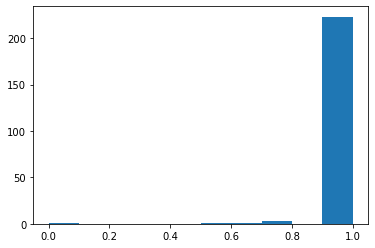

In [15]:
plt.hist( ypred )

In [34]:
# create goodface_prob feature to the image dataframe
img_df['goodface_prob'] = ypred

In [32]:
# check if bad faces are detected
garbage = img_df[img_df['goodface_prob']<0.5].index.values
print(garbage)

[142]


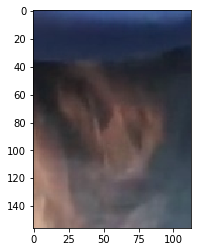

In [33]:
plt.imshow(cv2.imread(img_df['abs_file'][garbage[0]]))

In [35]:
# check if bad faces are detected
goodface = img_df[img_df['goodface_prob']>0.95].index.values
print(goodface[0:10])

[0 1 2 3 4 5 6 7 8 9]


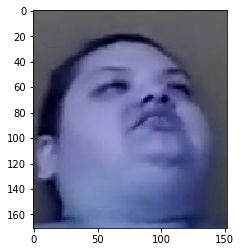

In [41]:
plt.imshow(cv2.imread(img_df['abs_file'][goodface[0]]))

In [45]:
project_utils.pickle_data('../data/img_df.pkl', img_df)

creating file ../data/img_df.pkl


In [46]:
img_df.head(5)

id                                                  abs_file  \
0   0  ../data/train_faces/REAL_trnp01_zwswwwrefl_106_f1id1.jpg   
1   1  ../data/train_faces/REAL_trnp00_vpmyeepbep_191_f1id1.jpg   
2   2  ../data/train_faces/FAKE_trnp01_cutfpzdonm_045_f1id1.jpg   
3   3  ../data/train_faces/FAKE_trnp00_runmncglnj_038_f1id1.jpg   
4   4  ../data/train_faces/FAKE_trnp00_hcqxrwzgxt_138_f1id1.jpg   

                              base_file   group           video  label  width  \
0  REAL_trnp01_zwswwwrefl_106_f1id1.jpg  trnp01  zwswwwrefl.mp4      1    171   
1  REAL_trnp00_vpmyeepbep_191_f1id1.jpg  trnp00  vpmyeepbep.mp4      1    228   
2  FAKE_trnp01_cutfpzdonm_045_f1id1.jpg  trnp01  cutfpzdonm.mp4      0    215   
3  FAKE_trnp00_runmncglnj_038_f1id1.jpg  trnp00  runmncglnj.mp4      0    219   
4  FAKE_trnp00_hcqxrwzgxt_138_f1id1.jpg  trnp00  hcqxrwzgxt.mp4      0    371   

   height    size  goodface_prob  
0     152   25992       0.999999  
1     140   31920       0.999936  
2     180   38700       0.999999  
3     130   28470       0.999047  
4     291  107961       1.000000

# Creation of dataframe of additional data

In [2]:
def generate_df_single_label(img_path, label, group):
    abs_files, base_files = project_utils.glob_folder_filelist(img_path)
    df = pd.DataFrame()
    df['abs_file'] = abs_files
    df['base_file'] = base_files
    df['group'] = group
    df['label'] = label
    return df

In [7]:
flickr_img_path = '../data/additional_data/flickrface_256/'
youtube_real_path = '../data/additional_data/youtube_real/'
youtube_fake_path = '../data/additional_data/youtube_fake/'

In [10]:
## perform filtering on flickr image dataset, to use only images with unlimited right

# read dataframe containing all flickr images comes with unlimited usage 
flickr_free_df = pd.read_csv('../data/flickr-free-files.csv')
flickr_free_list = flickr_free_df.filename.tolist()

# all images in the flickr folder are real 
flickr_df = generate_df_single_label(flickr_img_path, 1, 'flickrface70k')

print(flickr_df.shape)
flickr_df = flickr_df[flickr_df['base_file'].isin(flickr_free_list)].reset_index(drop=True)
print(flickr_df.shape)

(69999, 4)
(40505, 4)


In [5]:
flickr_df.head(5)

abs_file  base_file          group  \
0  ../data/additional_data/flickrface_256/27642.jpg  27642.jpg  flickrface70k   
1  ../data/additional_data/flickrface_256/38858.jpg  38858.jpg  flickrface70k   
2  ../data/additional_data/flickrface_256/10088.jpg  10088.jpg  flickrface70k   
3  ../data/additional_data/flickrface_256/32777.jpg  32777.jpg  flickrface70k   
4  ../data/additional_data/flickrface_256/47772.jpg  47772.jpg  flickrface70k   

   label  
0      1  
1      1  
2      1  
3      1  
4      1

In [13]:
# all images in the youtube_real folder are real
youtube_real_df = generate_df_single_label(youtube_real_path, 1, 'youtube')

# all images in the youtube_FAKE folder are fake
youtube_fake_df = generate_df_single_label(youtube_fake_path, 0, 'youtube')

print(youtube_real_df.shape)
print(youtube_fake_df.shape)

(909, 4)
(1355, 4)


In [14]:
# combine all three dataframe together
additional_df = pd.concat([flickr_df, youtube_real_df, youtube_fake_df], axis=0).reset_index(drop=True)

In [15]:
additional_df['group'].value_counts()

flickrface70k    40505
youtube           2264
Name: group, dtype: int64

In [16]:
additional_df['label'].value_counts()

1    41414
0     1355
Name: label, dtype: int64

In [17]:
project_utils.pickle_data('../data/additional_df.pkl', additional_df)

creating file ../data/additional_df.pkl


In [18]:
additional_df = project_utils.load_data('../data/additional_df.pkl')

In [19]:
print(additional_df.shape)
additional_df[additional_df['group']=='youtube'].head(5)

(42769, 4)


abs_file       base_file  \
40505   ../data/additional_data/youtube_real/REAL_4057.jpg   REAL_4057.jpg   
40506   ../data/additional_data/youtube_real/REAL_3805.jpg   REAL_3805.jpg   
40507  ../data/additional_data/youtube_real/REAL_13695.jpg  REAL_13695.jpg   
40508   ../data/additional_data/youtube_real/REAL_3544.jpg   REAL_3544.jpg   
40509   ../data/additional_data/youtube_real/REAL_2917.jpg   REAL_2917.jpg   

         group  label  
40505  youtube      1  
40506  youtube      1  
40507  youtube      1  
40508  youtube      1  
40509  youtube      1